
# Neural-HMM synthesis notebook

## Location of the model checkpoints

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 3

## Import libraries and setup matplotlib

In [3]:
import matplotlib.pylab as plt

# # Download tokenizer if not present
# import nltk
# nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch
import warnings

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import cleaned_text_to_sequence, intersperse, _clean_text, sequence_to_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
from hifigandenoiser import Denoiser
%matplotlib inline
from pathlib import Path


from src.utilities.plotting import generate_motion_visualization



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
%ls checkpoints/DiffMotionGradTTSBetter

checkpoint_0.ckpt      checkpoint_20500.ckpt  checkpoint_32000.ckpt
checkpoint_10000.ckpt  checkpoint_21000.ckpt  checkpoint_32500.ckpt
checkpoint_1000.ckpt   checkpoint_21500.ckpt  checkpoint_33000.ckpt
checkpoint_10500.ckpt  checkpoint_22000.ckpt  checkpoint_33500.ckpt
checkpoint_11000.ckpt  checkpoint_22500.ckpt  checkpoint_34000.ckpt
checkpoint_11500.ckpt  checkpoint_23000.ckpt  checkpoint_34500.ckpt
checkpoint_12000.ckpt  checkpoint_23500.ckpt  checkpoint_35000.ckpt
checkpoint_12500.ckpt  checkpoint_24000.ckpt  checkpoint_3500.ckpt
checkpoint_13000.ckpt  checkpoint_24500.ckpt  checkpoint_35500.ckpt
checkpoint_13500.ckpt  checkpoint_25000.ckpt  checkpoint_36000.ckpt
checkpoint_14000.ckpt  checkpoint_2500.ckpt   checkpoint_4000.ckpt
checkpoint_14500.ckpt  checkpoint_25500.ckpt  checkpoint_4500.ckpt
checkpoint_15000.ckpt  checkpoint_26000.ckpt  checkpoint_5000.ckpt
checkpoint_1500.ckpt   checkpoint_26500.ckpt  checkpoint_500.ckpt
checkpoint_15500.ckpt  checkpoint_27000.ckpt  checkpoi

In [6]:
checkpoint_path = "checkpoints/DiffMotionGradTTSBetter/checkpoint_36000.ckpt"

## Plotting code

In [7]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

## Setup hparams

In [8]:
hparams = create_hparams()

In [9]:
hparams.motion_decoder_type = "gradtts"

In [10]:
x = torch.load(checkpoint_path, map_location="cuda")
# # x['hyper_parameters']['encoder_type'] = "transformer"
# # # x['hyper_parameters']['encoder_params'] = {
# # #             "conv": {"kernel_size": 5, "n_convolutions": 3, "hidden_channels": 512, "state_per_phone": 2},
# # #             "transformer": {
# # #                 "hidden_channels": 384,
# # #                 "n_layer": 6,
# # #                 "n_head": 1,
# # #                 "d_head": 64,
# # #                 "d_inner": 1024,
# # #                 "kernel_size": 3,
# # #                 "dropout": 0.1,
# # #                 "dropatt": 0.1,
# # #                 "dropemb": 0.0,
# # #                 "embed_input": False,
# # #                 "pre_lnorm": True,
# # #                 "rel_attention": True,
# # #             },
# # #         }
# # torch.save(x, checkpoint_path)

In [11]:
x['hyper_parameters']['motion_visualizer'] = hparams.motion_visualizer
# x['hyper_parameters']['base_sampling_temperature_audio'] = 0.334
# x['hyper_parameters']['base_sampling_temperature_motion'] = 0.0

# x['hyper_parameters']['n_motion_joints'] = hparams.n_motion_joints
# x['hyper_parameters']['base_sampling_temperature'] = hparams.base_sampling_temperature
torch.save(x, checkpoint_path)


In [12]:
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

In [13]:
model

TrainingModule(
  (model): OverFlow(
    (embedding): Embedding(152, 384)
    (encoder): Encoder(
      (encoder): TransformerEncoder(
        (encoder): FFTransformer(
          (pos_emb): PositionalEmbedding()
          (drop): Dropout(p=0.0, inplace=False)
          (layers): ModuleList(
            (0-5): 6 x TransformerLayer(
              (dec_attn): MultiHeadAttn(
                (qkv_net): Linear(in_features=384, out_features=192, bias=True)
                (drop): Dropout(p=0.1, inplace=False)
                (dropatt): Dropout(p=0.1, inplace=False)
                (o_net): Linear(in_features=64, out_features=384, bias=False)
                (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
              )
              (pos_ff): PositionwiseConvFF(
                (CoreNet): Sequential(
                  (0): Conv1d(384, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
                  (1): ReLU()
                  (2): Conv1d(1024, 384, kernel_size=(3,),

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 42,597,666 trainable parameters


## Load Hifi-gan for mel2audio synthesis and denoiser

In [15]:
def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [16]:
# load the hifi-gan model
hifigan_loc = 'hifigan/'
config_file = hifigan_loc + 'config_v1.json'
hifi_checkpoint_file = 'g_02500000'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

In [17]:
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval().half()
generator.remove_weight_norm()

denoiser = Denoiser(generator, mode='zeros')

g_02500000
Loading 'g_02500000'
Complete.
Removing weight norm...


### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [18]:
model.model.hmm.hparams.max_sampling_time = 10000
model.model.hmm.hparams.duration_quantile_threshold=0.3
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=False
model.model.hmm.hparams.prenet_dropout_while_eval=False

## Set texts

In [19]:
texts = [
    "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS."
]

In [20]:
test_sentences = {
    1: "WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR THEY ACT AS A PRISM AND FORM A RAINBOW.",
    2: "THESE TAKE THE SHAPE ; OF A LONG ROUND ARCH, WITH ITS PATH HIGH ABOVE, AND ITS TWO ENDS APPARENTLY BEYOND THE HORIZON.",
    3: "WHEN A MAN LOOKS FOR SOMETHING BEYOND HIS REACH, HIS FRIENDS SAY HE IS LOOKING FOR THE POT OF GOLD AT THE END OF THE RAINBOW.",
    4: "IF THE RED OF THE SECOND BOW FALLS UPON THE GREEN OF THE FIRST, THE RESULT IS TO GIVE A BOW WITH AN ABNORMALLY WIDE YELLOW BAND.",
    5: "THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPER IMPOSITION OF A NUMBER OF BOWS.",
    6: "THE DIFFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS.",
    7: "IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS.",
    8: "IN ENHANCING AGENT CAPABILITIES, IT WILL BE IMPORTANT TO CONSIDER OTHER SALIENT PROPERTIES OF THIS PROCESS IN HUMANS.",
    9: "IN A WAY THAT COULD SUPPORT DISCOVERY OF SUB GOALS AND HIERARCHICAL PLANNING.",
    10: "DISTILLING INTELLIGENCE INTO AN ALGORITHMIC CONSTRUCT AND COMPARING IT TO THE HUMAN BRAIN MIGHT YIELD INSIGHTS.",
    11: "THE VAULT THAT WAS SEARCHED HAD IN FACT BEEN EMPTIED EARLIER THAT SAME DAY.",
    12: "ANT LIVES NEXT TO GRASSHOPPER, ANT SAYS, I LIKE TO WORK EVERY DAY.",
    13: "YOUR MEANS OF TRANSPORT FULFIL ECONOMIC REQUIREMENTS IN YOUR CHOSEN COUNTRY.",
    14: "SLEEP STILL FOGGED MY MIND AND ATTEMPTED TO FIGHT BACK THE PANIC.",
    15: "SUDDENLY, I SAW TWO FAST AND FURIOUS ; FEET DRIBBLING THE ; BALL TOWARDS MY GOAL.",
}

# texts = [" ".join(test_sentences.values())]
texts = [list(test_sentences.values())[0]]

texts = [
#     "; , Finish at like six; , or maybe seven or eight; then we'd all go out, you know have a few drinks head out to a nightclub or something like that come home."
  "; I don't want to go out. I will rather stay at home instead of going out, it is cold outside."  
]

In [21]:
# texts = [
#     "We propose a new approach, OverFlow, to address the shortcomings of neural HMM TTS (a type of transducer TTS) by adding flows over them. Having a stronger probabilistic model, we can now describe the highly non-Gaussian distribution of speech acoustics, WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR ; THEY ACT AS A PRISM AND FORM A RAINBOW. IN THIS PERSPECTIVE, WE HAVE REVIEWED SOME OF THE MANY WAYS IN WHICH NEUROSCIENCE HAS MADE FUNDAMENTAL CONTRIBUTIONS."
# ]

In [22]:
def get_text(i, text):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = _clean_text(text, hparams.text_cleaners)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = cleaned_text_to_sequence(text)    
    if hparams.add_blank:
        sequence = intersperse(sequence, 0)
    sequence = torch.LongTensor(sequence).to(device)
    print(''.join(['='] * 100))
    return sequence

In [23]:
sequences = []

for i, text in enumerate(texts):
    sequence = get_text(i, text)
    sequences.append(sequence)


********************
1 - Input text: 
********************
; I don't want to go out. I will rather stay at home instead of going out, it is cold outside.

********************
1 - Phonetised text: 
********************
; ˈaɪ dˈoʊnt wˈɔnt tə ɡˌoʊ ˈaʊt. ˈaɪ wɪl ɹˈæðɚ stˈeɪ æt hˈoʊm ɪnstˈɛd ʌv ɡˌoʊɪŋ ˈaʊt, ɪɾ ɪz kˈoʊld aʊtsˈaɪd.


In [24]:
sequence

tensor([  0,   1,   0,  16,   0, 130,   0,  17,   0,  76,   0,  16,   0,  20,
          0, 130,   0,  31,   0, 109,   0,  30,   0,  36,   0,  16,   0,  39,
          0, 130,   0,  50,   0,  30,   0,  36,   0,  16,   0,  36,   0,  57,
          0,  16,   0,  66,   0, 131,   0,  31,   0, 109,   0,  16,   0, 130,
          0,  17,   0, 109,   0,  36,   0,   4,   0,  16,   0, 130,   0,  17,
          0,  76,   0,  16,   0,  39,   0,  76,   0,  28,   0,  16,   0,  97,
          0, 130,   0,  46,   0,  55,   0,  59,   0,  16,   0,  35,   0,  36,
          0, 130,   0,  21,   0,  76,   0,  16,   0,  46,   0,  36,   0,  16,
          0,  24,   0, 130,   0,  31,   0, 109,   0,  29,   0,  16,   0,  76,
          0,  30,   0,  35,   0,  36,   0, 130,   0,  60,   0,  20,   0,  16,
          0, 112,   0,  38,   0,  16,   0,  66,   0, 131,   0,  31,   0, 109,
          0,  76,   0,  86,   0,  16,   0, 130,   0,  17,   0, 109,   0,  36,
          0,   3,   0,  16,   0,  76,   0,  99,   0,  16,   0,  

In [25]:
sequence_to_text(sequence.tolist())

'_;_ _ˈ_a_ɪ_ _d_ˈ_o_ʊ_n_t_ _w_ˈ_ɔ_n_t_ _t_ə_ _ɡ_ˌ_o_ʊ_ _ˈ_a_ʊ_t_._ _ˈ_a_ɪ_ _w_ɪ_l_ _ɹ_ˈ_æ_ð_ɚ_ _s_t_ˈ_e_ɪ_ _æ_t_ _h_ˈ_o_ʊ_m_ _ɪ_n_s_t_ˈ_ɛ_d_ _ʌ_v_ _ɡ_ˌ_o_ʊ_ɪ_ŋ_ _ˈ_a_ʊ_t_,_ _ɪ_ɾ_ _ɪ_z_ _k_ˈ_o_ʊ_l_d_ _a_ʊ_t_s_ˈ_a_ɪ_d_._'

## Decode text input and plot results

In [81]:
t = {
    'audio' :0.667,
    'motion': 0.0,
}
t = 0.334


In [121]:
from tqdm.auto import tqdm
with torch.no_grad():
    mel_outputs, motion_outputs = [], []
    for sequence in tqdm(sequences, leave=False):
        mel_output, motion_output, hidden_state_travelled, _, _ = model.sample(sequence, sampling_temp=t)
        mel_outputs.append(mel_output)
        motion_outputs.append(motion_output)
        

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualisations of the output

0 ; I don't want to go out. I will rather stay at home instead of going out, it is cold outside.


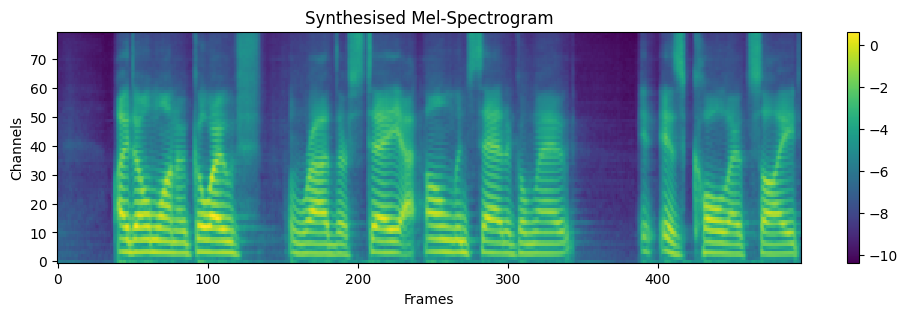

In [122]:
for i, mel_output in enumerate(mel_outputs):
    print(i, texts[i])
    plot_spectrogram_to_numpy(np.array(mel_output.float().cpu()).T)

### Synthesize audio from spectrogram using HiFiGAN

### Interesting denoising

In [123]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = mel_output.transpose(1, 2)
        audio = generator(mel_output)
        audio = denoiser(audio[:, 0], strength=0.001)[:, 0]
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: ; I don't want to go out. I will rather stay at home instead of going out, it is cold outside.


***********************************



In [124]:
# import soundfile as sf
# from pymo.viz_tools import render_mp4
# from pymo.writers import BVHWriter
# from pymo.preprocessing import MocapParameterizer
# from src.utilities.plotting import combine_video_audio

# def generate_motion_visualization(
#     audio, audio_filename, motion, motion_filename, motion_visualizer_pipeline, bvh_filename
# ):
#     """

#     Args:
#         audio (_type_): (1, T_audio)
#         audio_filename (_type_): str/path
#         motion (_type_): (T_motion, 45)
#         motion_filename (_type_): str/path
#         motion_visualizer_pipeline (_type_): Pipeline
#         bvh_filename (_type_, optional): str/path. Defaults to None.
#     """
#     audio_filename = Path(audio_filename)
#     motion_filename = Path(motion_filename)

    
#     sf.write(audio_filename, audio.flatten(), 22500, "PCM_24")

#     # Add motion target
#     bvh_values = motion_visualizer_pipeline.inverse_transform([motion])    
# #     bvh_values[0].framerate = bvh_values[0].framerate * (120 / 86.6)
# #     import pdb; pdb.set_trace()
#     if bvh_filename is not None:
#         # Write input bvh file
#         writer = BVHWriter()
#         with open(bvh_filename, "w") as f:
#             writer.write(bvh_values[0], f)

#     # To stickfigure
#     X_pos = MocapParameterizer("position").fit_transform(bvh_values)

#     render_mp4(X_pos[0], motion_filename.with_suffix(".temp.mp4"), axis_scale=200)
#     combine_video_audio(
#         motion_filename.with_suffix(".temp.mp4"),
#         audio_filename,
#         motion_filename,
#     )

### Synthesise motion

In [125]:
l = motion_output.shape[-1]

In [126]:
import torch.nn.functional as F

print(motion_output.shape)
motion_output = motion_output[:, :, ::4]

torch.Size([1, 45, 496])


In [127]:
motion_output.shape, l

(torch.Size([1, 45, 124]), 496)

In [128]:
motion_output = F.interpolate(motion_output, size=l, mode='nearest-exact')

In [129]:
output_folder = Path('syn_motion_output')
output_folder.mkdir(exist_ok=True, parents=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, motion_output in tqdm(enumerate(motion_outputs)):
        generate_motion_visualization(audios[i].cpu(), output_folder/f'{i+1}.wav', motion_output.cpu().squeeze(0).T, output_folder/f'{i+1}.mp4', hparams.motion_visualizer, output_folder/f'{i+1}.bvh')
    

0it [00:00, ?it/s]

MocapParameterizer: position


ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/smehta/anaconda3/envs/LightningTacotron --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample  

In [120]:
ipd.Video(output_folder/f'{1}.mp4')

In [130]:
ipd.Video(output_folder/f'{1}.mp4')

### Save to wav files using soundfile

In [ ]:
import soundfile as sf
from pathlib import Path

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
        filename = basepath / f'OverFlow_{i + 1}.wav'
        sr = 22500
        sf.write(filename, audio.data.squeeze().cpu().numpy(), 
                 22500, 'PCM_24')
        print(f'Successfully written: {filename}')
